# SWAN boundary examples

This notebooks shows examples of how to prescribe spectral boundaries using
the boundary data classes and swan components

In [1]:
%load_ext autoreload
%autoreload 2

import os
import shutil
from pathlib import Path
from tempfile import mkdtemp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import pandas as pd
import wavespectra

import warnings
warnings.filterwarnings('ignore')

In [2]:
from rompy.core.data import SourceFile
from rompy.core.time import TimeRange
from rompy.swan.grid import SwanGrid

In [46]:
def read_tpar(tparfile):
    df = pd.read_csv(
        tparfile,
        sep=" ",
        header=None,
        skiprows=1,
        parse_dates=[0],
        date_format="%Y%m%d.%H%M%S",
        index_col=0,
    )
    df.columns = ["hs", "tp", "dpm", "dspr"]
    return df

In [3]:
datadir = Path("../../tests/data")
modeldir = Path("model")
modeldir.mkdir(exist_ok=True)

### Define rompy objects

Create instances of source, time and grid objects to use with the boundary classes

In [4]:
# source defines the dataset to be used to create the model boundary

source = SourceFile(
    uri=datadir / "aus-20230101.nc",
    kwargs=dict(engine="netcdf4"),
)
dset = source.open()
dset

<xarray.Dataset>
Dimensions:  (time: 5, site: 412, freq: 11, dir: 8)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01 2023-01-01T06:00:00 ... 2023-01-02
  * site     (site) int64 0 4 8 12 16 20 24 ... 1624 1628 1632 1636 1640 1644
  * freq     (freq) float32 0.05417 0.05959 0.06555 ... 0.1161 0.1277 0.1405
  * dir      (dir) float32 0.0 45.0 90.0 135.0 180.0 225.0 270.0 315.0
Data variables:
    lon      (site) float32 ...
    lat      (site) float32 ...
    efth     (time, site, freq, dir) float64 ...
    dpt      (time, site) float32 ...
    wspd     (time, site) float32 ...
    wdir     (time, site) float32 ...
Attributes: (12/16)
    product_name:           ww3.all_spec.nc
    area:                   Global 0.5 x 0.5 degree
    data_type:              OCO spectra 2D
    format_version:         1.1
    southernmost_latitude:  n/a
    northernmost_latitude:  n/a
    ...                     ...
    minimum_altitude:       n/a
    maximum_altitude:       n/a
    altitude_resolution:    n/a
    start_date:             2023-01-01 00:00:00
    stop_date:              2023-02-01 00:00:00
    field_type:             3-hourly

In [24]:
# times prescribe the times over which the model will run

times = TimeRange(start="2023-01-01T00", end="2023-01-02T00", interval="6h")
times

TimeRange(start=datetime.datetime(2023, 1, 1, 0, 0), end=datetime.datetime(2023, 1, 2, 0, 0), duration=datetime.timedelta(days=1), interval=datetime.timedelta(seconds=21600), include_end=True)

In [25]:
# grid defines the model grid

grid = SwanGrid(x0=112, y0=-29, dx=0.5, dy=0.5, nx=8, ny=9, rot=20)
grid

SwanGrid: REG, 8x9

Plot model grid and boundary points in the source spectra

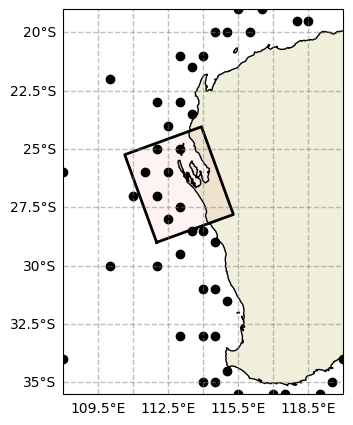

In [26]:
fig, ax = grid.plot(fscale=5)
ax.plot(dset.lon, dset.lat, "ok")
ax.set_extent([108, 120, -35.5, -19])

## BOUNDSPEC SIDE

Boundary of type `BOUndspec SIDE` can be specified from existing spectral data using
the `rompy.swan.boundary.BoundspecSide` object. The boundary location is defined as the
middle point of a side of a specified grid object and the boundary spectra are
interpolated from a spectral source at that locaion.

This class only supports `FILE` type boundary since the `PAR` type does not allow for
nonstationary boundary specification (`PAR` type boundary can be defined by using the
components it required).

We currently support `TPAR` and `SPEC2D` file types.


In [27]:
from rompy.swan.boundary import BoundspecSide

workspace = Path(mkdtemp(dir="model"))

### TPAR

In [28]:
dset.time.values
times

TimeRange(start=datetime.datetime(2023, 1, 1, 0, 0), end=datetime.datetime(2023, 1, 2, 0, 0), duration=datetime.timedelta(days=1), interval=datetime.timedelta(seconds=21600), include_end=True)

In [47]:
bnd = BoundspecSide(
    id="wa", source=source, sel_method="idw", tolerance=2.0, location={"side": "west"}
)

cmd = bnd.get(destdir=workspace, grid=grid, time=times)
filename = f'{bnd.id}_{bnd.file_type}_{bnd.location.side}_000.bnd'

print(f"{cmd}\n")
os.system(f"cat {workspace / filename}");

BOUNDSPEC SIDE WEST CCW CONSTANT FILE fname='wa_tpar_west_000.bnd' seq=1

TPAR
20230101.000000 2.74 14.39 223.83 30.07
20230101.060000 2.80 14.03 223.88 31.27
20230101.120000 3.07 14.04 223.26 32.15
20230101.180000 3.48 14.17 223.08 33.61
20230102.000000 3.52 14.21 223.68 33.73


In [48]:
# Load the boundary created as a dataframe

df = read_tpar(workspace / filename)
df

,hs,tp,dpm,dspr
0,,,,
2023-01-01 00:00:00,2.74,14.39,223.83,30.07
2023-01-01 06:00:00,2.80,14.03,223.88,31.27
2023-01-01 12:00:00,3.07,14.04,223.26,32.15
2023-01-01 18:00:00,3.48,14.17,223.08,33.61
2023-01-02 00:00:00,3.52,14.21,223.68,33.73


Plot model grid and boundary Hs

In [51]:
def plot_boundary_side(bnd, dset, df, grid, time):

    xb, yb = bnd._boundary_points(grid)

    fig, axs = plt.subplots(1, 3, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(15, 3.5))

    # Hs
    ax = axs[0]
    p = ax.scatter(dset.lon, dset.lat, s=50, c=dset.sel(time=time).spec.hs(), cmap="turbo", vmin=2.0, vmax=3.5)
    ax.scatter(xb, yb, s=200, c=df.loc[time]["hs"], marker=">", edgecolor="k", cmap="turbo", vmin=2.0, vmax=3.5)
    plt.colorbar(p, label="Hs (m)")

    # Tp
    ax = axs[1]
    p = ax.scatter(dset.lon, dset.lat, s=50, c=dset.sel(time=time).spec.tp(), cmap="viridis", vmin=13.8, vmax=14.5)
    ax.scatter(xb, yb, s=200, c=df.loc[time]["tp"], marker=">", edgecolor="k", cmap="viridis", vmin=13.8, vmax=14.5)
    plt.colorbar(p, label="Tp (s)")

    # Dpm
    ax = axs[2]
    p = ax.scatter(dset.lon, dset.lat, s=50, c=dset.sel(time=time).spec.dpm(), cmap="hsv", vmin=220, vmax=225)
    ax.scatter(xb, yb, s=200, c=df.loc[time]["dpm"], marker=">", edgecolor="k", cmap="hsv", vmin=220, vmax=225)
    plt.colorbar(p, label="Dpm (deg)")

    for ax in axs:
        grid.plot(ax=ax, fscale=5)
        ax.set_extent([110.5, 115.5, -29.5, -23.5])
        ax.set_title(time)
        ax.coastlines()

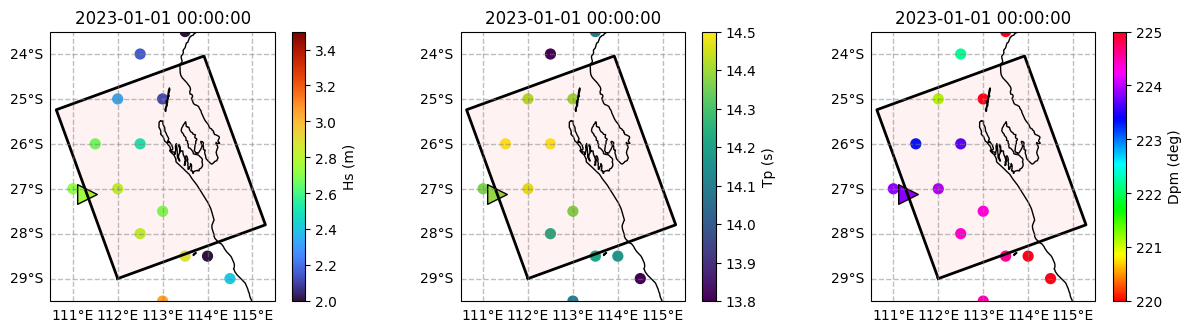

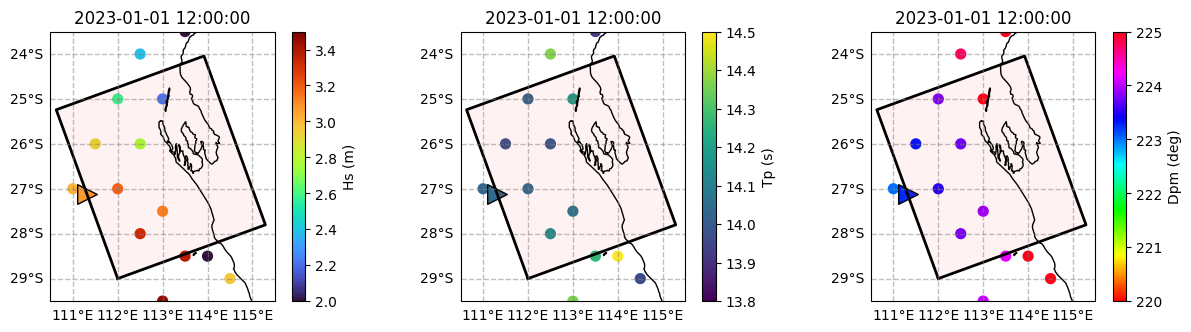

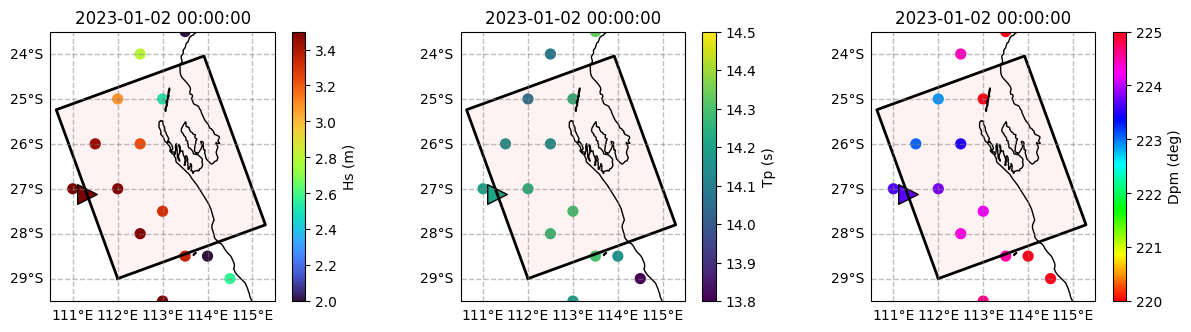

In [52]:
for time in df.index[::2]:
    plot_boundary_side(bnd, dset, df, grid, time)

### SPEC2D

In [53]:
bnd = BoundspecSide(
    id="wa",
    source=source,
    sel_method="idw",
    tolerance=2.0,
    location={"side": "west"},
    file_type="spec2d",
)

cmd = bnd.get(destdir=workspace, grid=grid, time=times)
filename = f'{bnd.id}_{bnd.file_type}_{bnd.location.side}_000.bnd'

print(cmd)

BOUNDSPEC SIDE WEST CCW CONSTANT FILE fname='wa_spec2d_west_000.bnd' seq=1


In [68]:
# Load the boundary created as a dataset

ds = wavespectra.read_swan(workspace / filename, as_site=True)
ds

<xarray.Dataset>
Dimensions:  (time: 5, site: 1, freq: 11, dir: 8)
Coordinates:
  * time     (time) datetime64[ns] 2023-01-01 2023-01-01T06:00:00 ... 2023-01-02
  * site     (site) <U18 'wa_spec2d_west_000'
  * freq     (freq) float64 0.05417 0.05959 0.06555 ... 0.1161 0.1277 0.1405
  * dir      (dir) float64 0.0 45.0 90.0 135.0 180.0 225.0 270.0 315.0
Data variables:
    efth     (time, site, freq, dir) float64 0.0 0.0 0.0 ... 6.713e-05 0.0
    lat      (site) float64 -27.12
    lon      (site) float64 111.3

Boundary stats from dataset for plotting

In [66]:
df = ds.isel(site=0, drop=True).spec.stats(["hs", "tp", "dpm", "dspr"]).to_pandas()
df

,hs,tp,dpm,dspr
time,,,,
2023-01-01 00:00:00,2.735211,14.395185,223.833069,30.052405
2023-01-01 06:00:00,2.800123,14.027714,223.883652,31.259804
2023-01-01 12:00:00,3.072918,14.040024,223.259933,32.139778
2023-01-01 18:00:00,3.475766,14.167553,223.081635,33.599873
2023-01-02 00:00:00,3.515422,14.212207,223.680557,33.722892


Plotting boundary stats

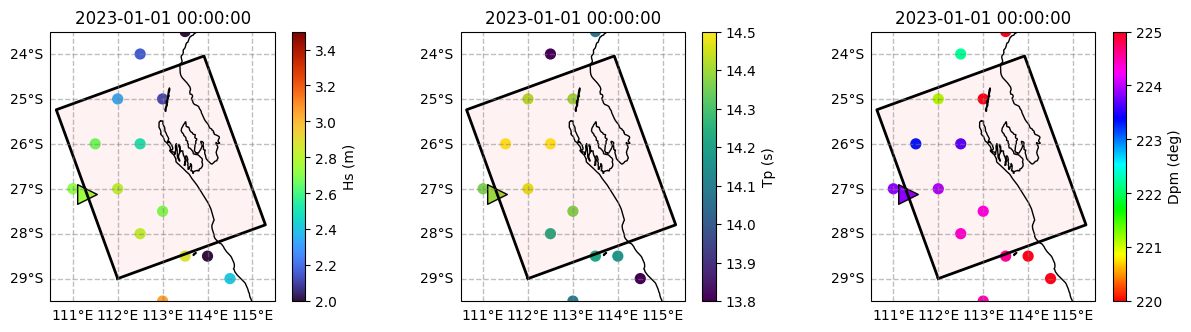

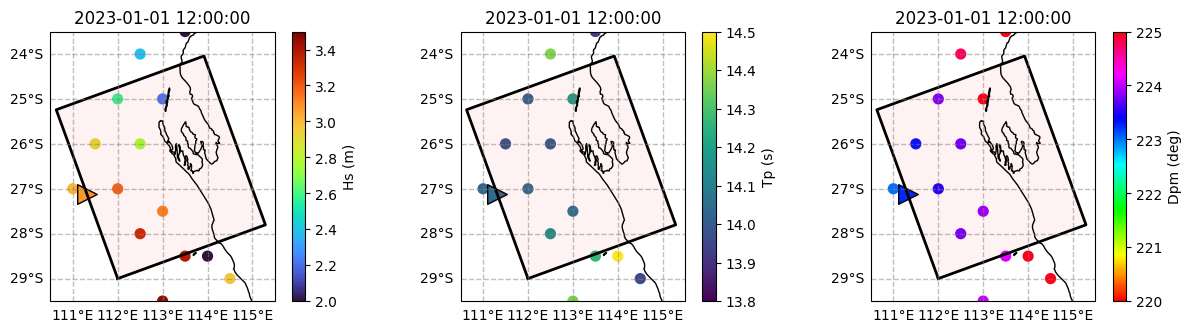

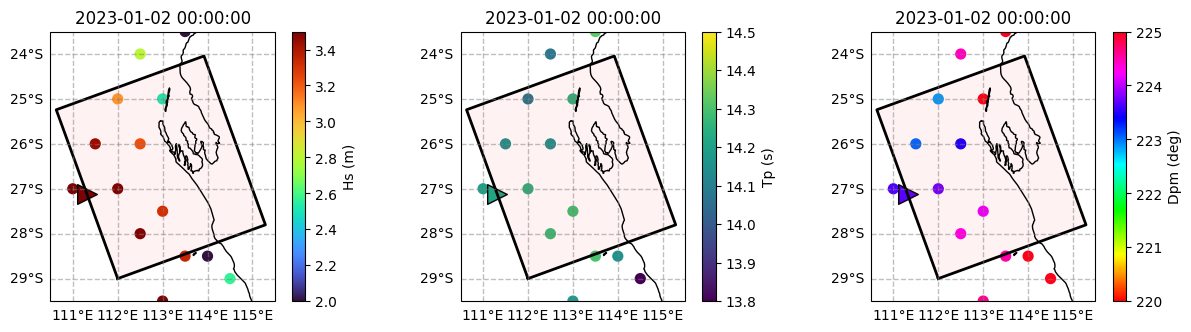

In [67]:
for time in df.index[::2]:
    plot_boundary_side(bnd, dset, df, grid, time)